In [34]:
from nilearn import datasets
#dir='/raid/nilearn_data'
adhd_dataset = datasets.fetch_adhd(n_subjects=10)
func_filenames = adhd_dataset.func  # list of 4D nifti files for each subject

# print basic information on the dataset
print('First functional nifti image (4D) is at: %s' %
      func_filenames[0])  # 4D data

from nilearn.decomposition import CanICA

canica = CanICA(smoothing_fwhm=6.,
                memory="nilearn_cache", memory_level=2,
                threshold=3., verbose=10, random_state=0)
x_train=canica.prepare_data(func_filenames)


First functional nifti image (4D) is at: /home/uga_qinglin/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz
[MultiNiftiMasker.fit] Loading data from [/home/uga_qinglin/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz, /home/uga_qinglin/nilearn_data/adhd/data/0010064/0010064_rest_tshift_RPI_voreg_mni.nii.gz, /home/uga_qinglin
[MultiNiftiMasker.fit] Computing mask
[MultiNiftiMasker.transform] Resampling mask
[CanICA] Loading data
/home/uga_qinglin/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz
/home/uga_qinglin/nilearn_data/adhd/data/0010064/0010064_rest_tshift_RPI_voreg_mni.nii.gz
/home/uga_qinglin/nilearn_data/adhd/data/0010128/0010128_rest_tshift_RPI_voreg_mni.nii.gz
/home/uga_qinglin/nilearn_data/adhd/data/0021019/0021019_rest_tshift_RPI_voreg_mni.nii.gz
/home/uga_qinglin/nilearn_data/adhd/data/0023008/0023008_rest_tshift_RPI_voreg_mni.nii.gz
/home/uga_qinglin/nilearn_data/adhd/data/0023012/0023012_rest_tshift_RPI

In [35]:
original_dim=x_train.shape[1]
print x_train.shape

(200, 64992)


In [37]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(original_dim,))
# "encoded" is the encoded representation of the input
encoded = Dense(128, activation='tanh',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
encoded = Dense(64, activation='tanh',
                activity_regularizer=regularizers.l1(10e-5))(encoded)
encoded = Dense(32, activation='tanh',
                activity_regularizer=regularizers.l1(10e-5))(encoded)

decoded = Dense(64, activation='tanh')(encoded)
decoded = Dense(128, activation='tanh')(decoded)
decoded = Dense(original_dim, activation='tanh')(decoded)


# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
#encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
#decoder_layer = autoencoder.layers[-1]
# create the decoder model
#decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=100,
                shuffle=True)

Epoch 1/50
200/200 [==============================] - 2s 10ms/step - loss: 4.1481
Epoch 2/50
200/200 [==============================] - 0s 2ms/step - loss: 3.6902
Epoch 3/50
200/200 [==============================] - 0s 2ms/step - loss: 3.1413
Epoch 4/50
200/200 [==============================] - 1s 3ms/step - loss: 2.8107
Epoch 5/50
200/200 [==============================] - 0s 2ms/step - loss: 2.5148
Epoch 6/50
200/200 [==============================] - 0s 2ms/step - loss: 2.3086
Epoch 7/50
200/200 [==============================] - 0s 2ms/step - loss: 2.0933
Epoch 8/50
200/200 [==============================] - 0s 2ms/step - loss: 1.9173
Epoch 9/50
200/200 [==============================] - 0s 2ms/step - loss: 1.7684
Epoch 10/50
200/200 [==============================] - 0s 2ms/step - loss: 1.6126
Epoch 11/50
200/200 [==============================] - 0s 2ms/step - loss: 1.5062
Epoch 12/50
200/200 [==============================] - 0s 2ms/step - loss: 1.4233
Epoch 13/50
200/200 [===

In [38]:
y=encoder.predict(x_train)
y.shape

(200, 32)

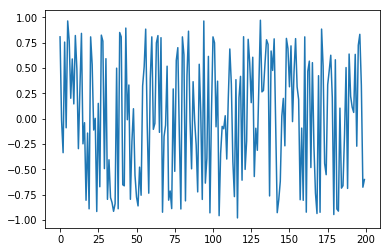

In [39]:
%matplotlib inline
import numpy as np
t = range(0, 200)

import matplotlib.pyplot as plt
plt.plot(t, y[:,1])

In [40]:
from sklearn.linear_model import Lasso
clf = Lasso(alpha=0.1)
clf.fit(y,x_train)
print(clf.coef_.shape)

(64992, 32)


In [41]:
#W=decoder_mean.get_weights()
#components_img=W[0]


In [42]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=canica.masker_.mask_img_, standardize=True)
masker.fit()

import numpy as np
components_img = masker.inverse_transform(np.transpose(clf.coef_))

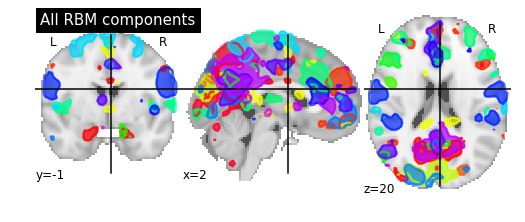

In [43]:
from nilearn import plotting

plotting.plot_prob_atlas(components_img, view_type='filled_contours',
                         title='All RBM components')

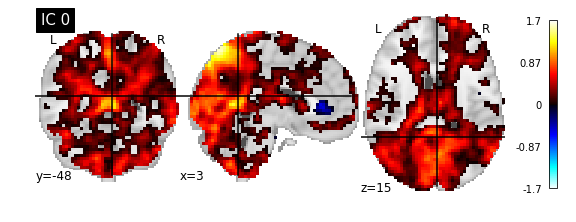

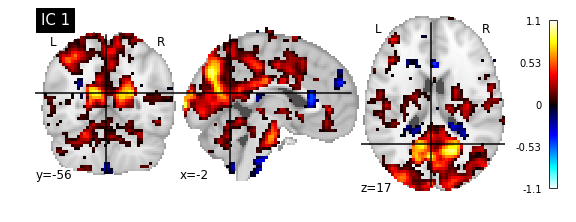

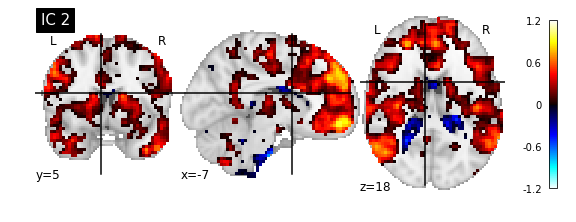

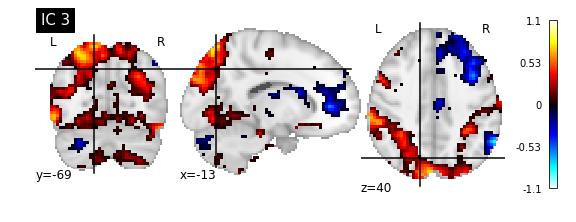

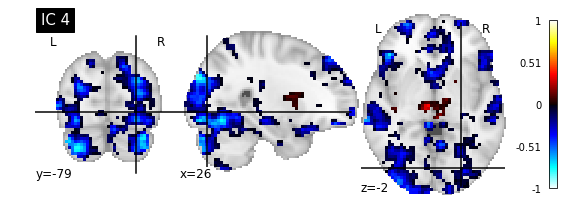

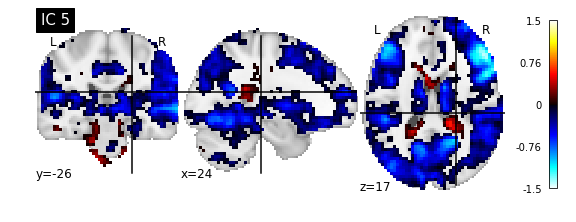

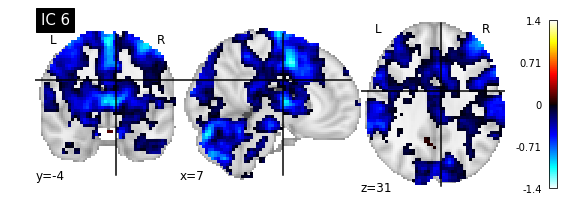

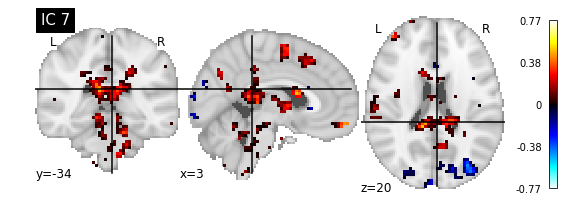

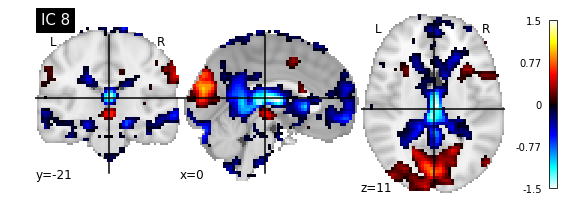

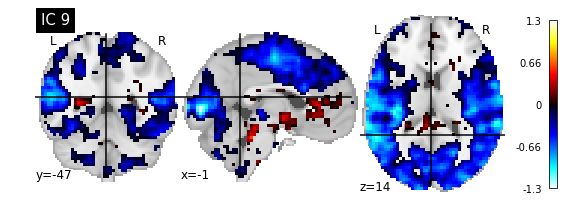

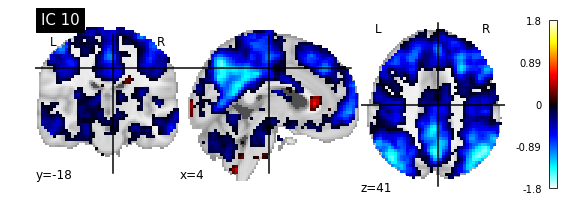

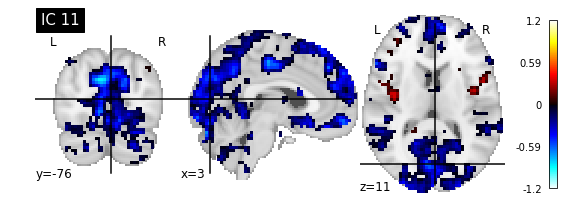

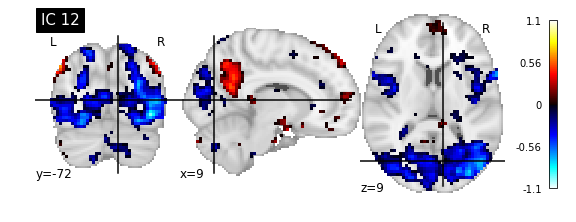

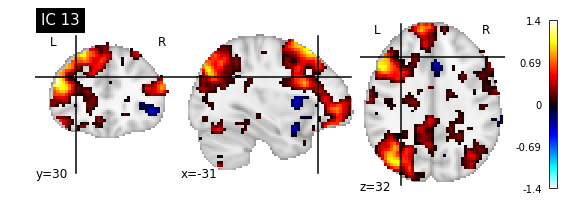

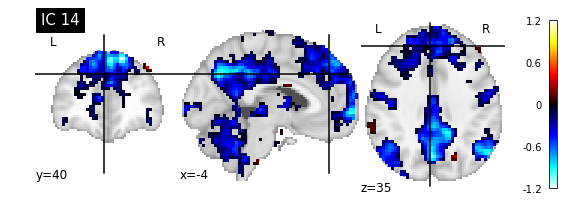

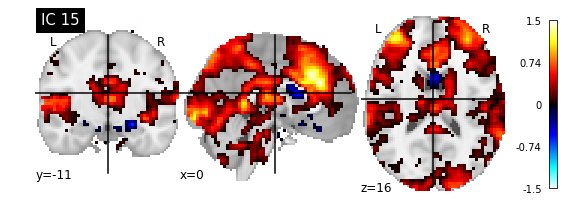

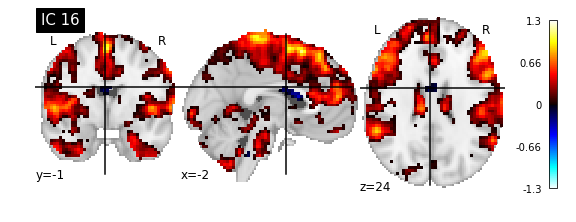

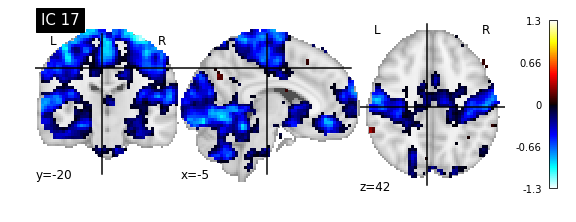

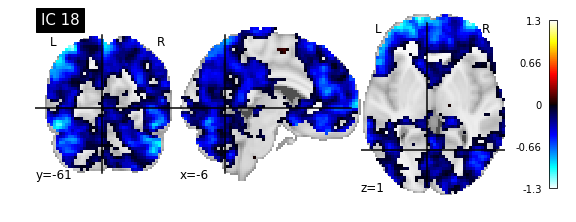

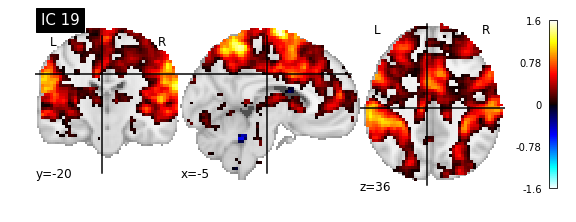

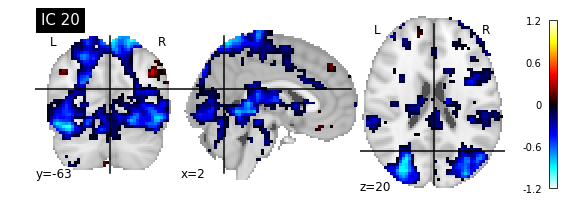

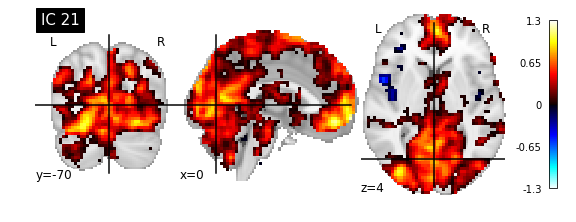

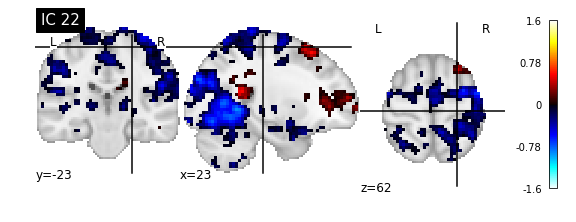

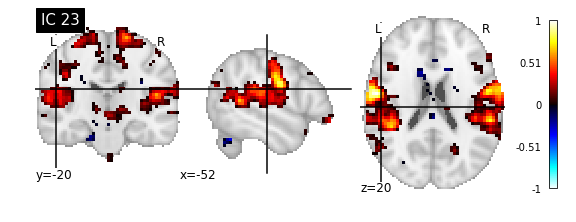

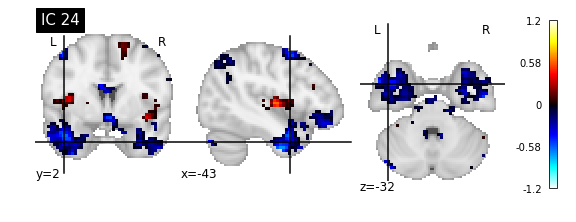

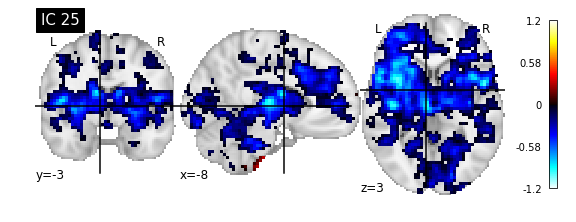

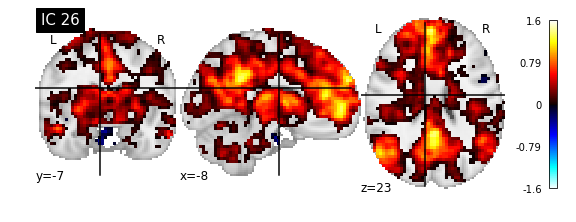

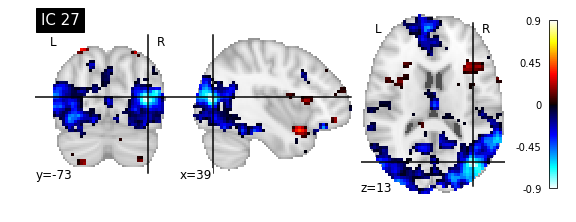

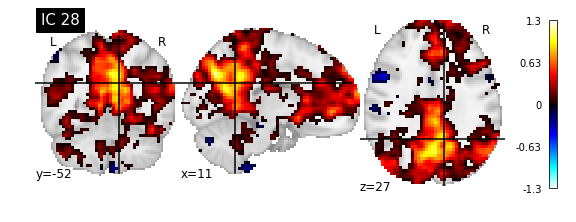

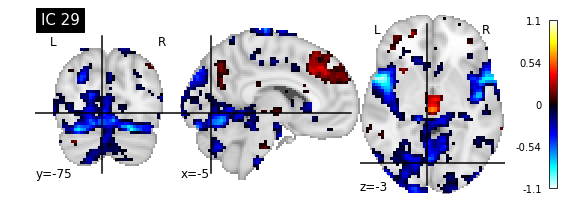

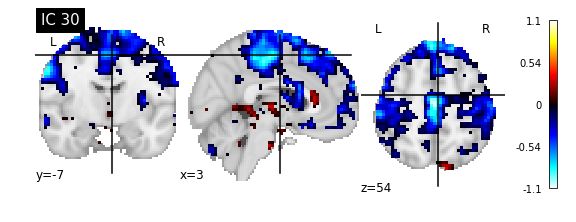

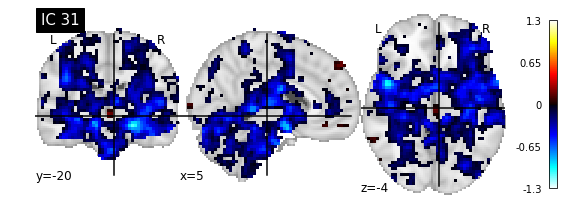

In [44]:
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show

for i, cur_img in enumerate(iter_img(components_img)):
    plot_stat_map(cur_img, display_mode="ortho", title="IC %d" % i,
                  cut_coords=None, colorbar='bwr')

show()